# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Train from scratch
2. Explore embeddings vectors
3. Use these for an NLP task

In [2]:
import os
import pickle
import time
import logging
from collections import defaultdict

# NLTK page : http://www.nltk.org/

In [3]:
import nltk
nltk.__version__

'3.2'

# Gensim page : https://radimrehurek.com/gensim/index.html

In [4]:
import gensim
gensim.__version__

c:\anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


'3.2.0'

# Scikit-learn page : http://scikit-learn.org/stable/

In [5]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
sklearn.__version__

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'0.19.1'

In [6]:
import numpy as np
np.__version__

'1.14.1'

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
from gensim.models import Word2Vec

In [10]:
%time nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
Wall time: 1.59 s


True

In [11]:
%time nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Wall time: 431 ms


True

In [12]:
%time nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\treebank.zip.
Wall time: 9.16 s


True

In [13]:
# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 82.2 ms


True

In [14]:
# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Wall time: 347 ms


True

In [15]:
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

In [16]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [17]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


# Pro Tip : Before we go on, it's good to know about the GenSim documentation for models, training, querying, etc:
https://radimrehurek.com/gensim/models/word2vec.html

In [18]:
# Let's determine what parameters we will use for the word2vec training
W2V_SKIP_GRAM = 0
W2V_DIMENSIONS = 200
W2V_MIN_COUNT = 3

In [19]:
# How many worker threads should we use to train?  Depends on your hardware...
W2V_WORKERS = 1

# Let's train some models...

In [20]:
%time brown_model = Word2Vec(brown.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 43.6 s


In [21]:
%time movie_model = Word2Vec(movie_reviews.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 35.1 s


In [22]:
%time treebank_model = Word2Vec(treebank.sents(), sg = W2V_SKIP_GRAM, size = W2V_DIMENSIONS, min_count = W2V_MIN_COUNT, workers = W2V_WORKERS)

Wall time: 17.4 s


In [23]:
print('Brown Model vocab size : ', len(brown_model.wv.vocab))
print('Movie Review Model vocab size : ', len(movie_model.wv.vocab))
print('Treebank Model vocab size : ', len(treebank_model.wv.vocab))

Brown Model vocab size :  22339
Movie Review Model vocab size :  20261
Treebank Model vocab size :  3959


# Save / Load models

In [24]:
# Before we go any further, we can save one of our models
brown_file_name = 'brown_' + time.strftime("%m_%d_%Y")
brown_model.save(brown_file_name)
print('Saved Model to : ' + brown_file_name)

Saved Model to : brown_04_02_2018


In [25]:
# and here's how we can load a model back in...
brown_loaded_model = Word2Vec.load(brown_file_name)
print('Brown LOADED Model vocab size : ', len(brown_loaded_model.wv.vocab))

Brown LOADED Model vocab size :  22339


# Let's start inspect our newly trained vectors

In [26]:
# Now let's inspect what some of these vectors look like
print(brown_model['business'])

[ 0.14736216 -0.09454245  0.33603722  0.0927493  -0.03580623  0.01609297
  0.22798343  0.12702626  0.05720199 -0.06163175  0.07217047 -0.03118005
  0.14651278 -0.07602914 -0.16530289 -0.03974365 -0.21107689  0.00447865
  0.05620869  0.10141774 -0.19843842 -0.45571518 -0.38035884  0.11404689
 -0.05722426 -0.07743788  0.11516336 -0.11658001 -0.20912996 -0.5463369
  0.05355069  0.15136252 -0.30661112  0.1334068  -0.12352191  0.18744595
  0.1871613  -0.04500855  0.15503025  0.08348822 -0.5949609  -0.31162682
  0.14311919 -0.00725582  0.03091478  0.1767173   0.28576046  0.09431834
 -0.02606687 -0.20625935 -0.1605864   0.1429803   0.27434635  0.381148
 -0.33291867  0.30771515 -0.1816988  -0.2600096  -0.30216047 -0.08235159
 -0.05599177  0.02941933 -0.21531066  0.12492674 -0.09079135 -0.07200029
 -0.1116586   0.04116455  0.0951772  -0.25573158 -0.11878213  0.12116463
  0.2616574  -0.36192635 -0.31357935  0.32578462  0.207766    0.13939299
 -0.15199915  0.28388306  0.08641988  0.31440178  0.18

c:\anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [27]:
print(movie_model.wv.most_similar(positive = ['movie'], topn = 10))

[('film', 0.9383960962295532), ('picture', 0.8647702932357788), ('sequel', 0.7505464553833008), ('case', 0.7233774662017822), ('ending', 0.712360143661499), ('premise', 0.7056243419647217), ('flick', 0.6901092529296875), ('plot', 0.6843247413635254), ('it', 0.6788074374198914), ('story', 0.6772277355194092)]


In [28]:
print(movie_model.wv.most_similar(positive = ['hanks'], topn = 10))

[('platt', 0.941641092300415), ('campbell', 0.9404139518737793), ('affleck', 0.9391530156135559), ('jason', 0.9387622475624084), ('richard', 0.9373754262924194), ('steve', 0.9364941120147705), ('thomas', 0.9351273775100708), ('ian', 0.9340677261352539), ('anthony', 0.9307847023010254), ('holm', 0.9306736588478088)]


In [29]:
# Now let's see how similar certain word pairs might be
TERM_SIMILARITY_1 = 'movie'
TERM_SIMILARITY_2 = 'film'

print(movie_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(brown_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))
print(treebank_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))

0.9383961596763736
0.921653647606394
0.9978409559590805


In [30]:
# Now let's try another pair
TERM_SIMILARITY_3 = 'computer'
TERM_SIMILARITY_4 = 'life'

print(movie_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(brown_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))
print(treebank_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))

0.18492650975041625
0.590815761657125
0.9992744866053838


In [31]:
# Can we replicate the famous example from this paper:
# "King - Man + Woman ~~ Queen"
# http://www.aclweb.org/anthology/N13-1#page=784
#RELATIONSHIP_WORD_1 = 'woman'
#RELATIONSHIP_WORD_2 = 'king'
#RELATIONSHIP_WORD_3 = 'man'

# this gives what we might expect from the MOVIE corpus
#RELATIONSHIP_WORD_1 = 'films'
#RELATIONSHIP_WORD_2 = 'movie'
#RELATIONSHIP_WORD_3 = 'film'

# this gives what we might expect from the BROWN corpus
RELATIONSHIP_WORD_1 = 'families'
RELATIONSHIP_WORD_2 = 'city'
RELATIONSHIP_WORD_3 = 'family'

#print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('towns', 0.939945638179779), ('classes', 0.9390415549278259), ('various', 0.9366419315338135), ('organizations', 0.9364495873451233), ('cities', 0.9362595677375793), ('methods', 0.9333494901657104), ('churches', 0.9328235983848572), ('roads', 0.9291653633117676), ('policies', 0.9282445311546326), ('programs', 0.9282330274581909)]


# Now let's try to visualize some of the embeddings vectors with reduced dimensions (by way of t-SNE)

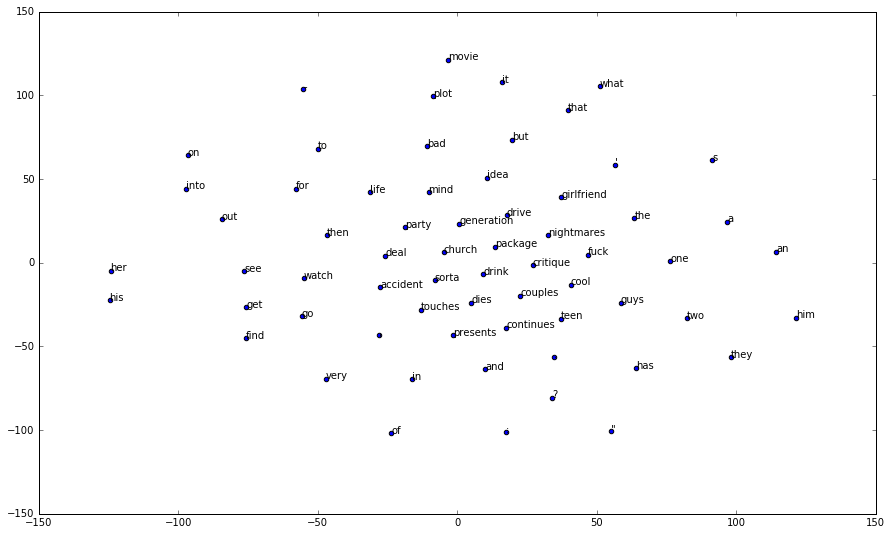

In [32]:
def plot_embeddings(w2v_model, target_terms):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        if target_term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model.wv[target_term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_terms, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
max_movie_sentences_to_visualize = 8
visualization_terms = set()
for sentence in movie_reviews.sents()[:max_movie_sentences_to_visualize]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings(movie_model, list(visualization_terms))

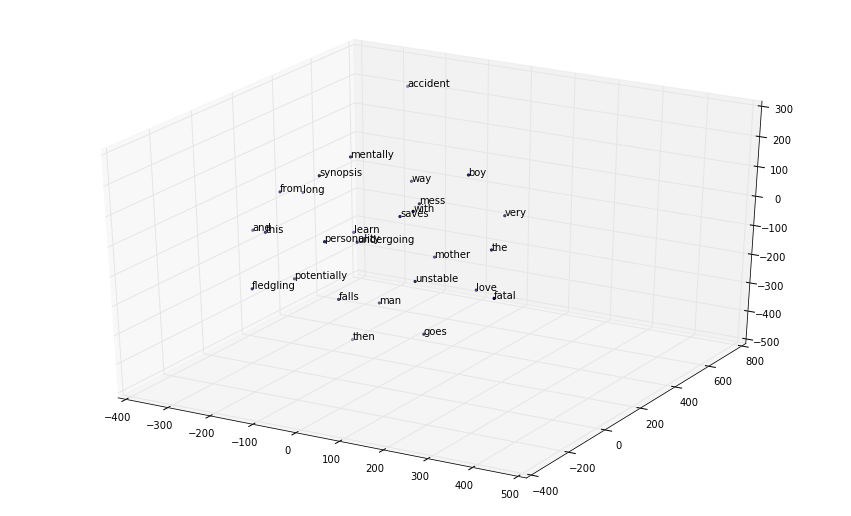

In [33]:
def plot_embeddings_3d(w2v_model, target_terms, min_word_length = 2):
    from mpl_toolkits.mplot3d import Axes3D
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    filtered_terms = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        # make sure that we're either not filtering or its above a certain length
        if min_word_length < 0 or len(target_term) > min_word_length:
            if target_term in w2v_model.wv.vocab:
                term_vectors.append(w2v_model.wv[target_term])
                filtered_terms.append(target_term)
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='.')
    for i, word in enumerate(filtered_terms):
        ax.text(x=Y[i,0], y=Y[i,1], z=Y[i,2], s=word)
    plt.show()
    
max_movie_sentences_to_visualize = 5
visualization_terms = set()
for sentence in movie_reviews.sents()[105:107]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings_3d(movie_model, list(visualization_terms))

{'during', 'below', 'ain', 'there', "she's", 'hasn', 'what', 'which', "don't", 'shan', 'do', 'her', 'until', 'of', 'further', 'more', 'she', 'am', 'nor', 'now', 'their', 'd', 'shouldn', 'was', 'been', 'all', 'won', 'ours', 'his', 'him', 'off', 'while', 'isn', 'himself', 'other', "isn't", "shan't", 'm', 'where', "you've", "hasn't", 'he', 'again', 'be', 'such', 'why', 'are', 'no', 'and', 'couldn', 'me', "wasn't", "you're", 'by', 'above', 'you', 'some', 'doing', 'about', 'from', 'both', "that'll", 'only', "aren't", 'over', 'itself', 'if', 'don', 'but', 'it', 'yourself', 'into', 'wouldn', 'mustn', 'same', 've', 'when', 'just', 'after', 'hadn', 'yourselves', 'mightn', 'themselves', 'they', 'who', 'doesn', 'having', 'its', 'had', 'will', "shouldn't", 'very', 'myself', "mustn't", 'didn', 'for', 'so', 'i', 'any', "won't", 'y', 'an', 'we', 'does', 'few', "it's", 'ma', 'yours', 'them', 'aren', 'here', 'out', "doesn't", 't', "wouldn't", 'because', 'to', 're', 'our', "weren't", 'is', 'at', 'wasn',

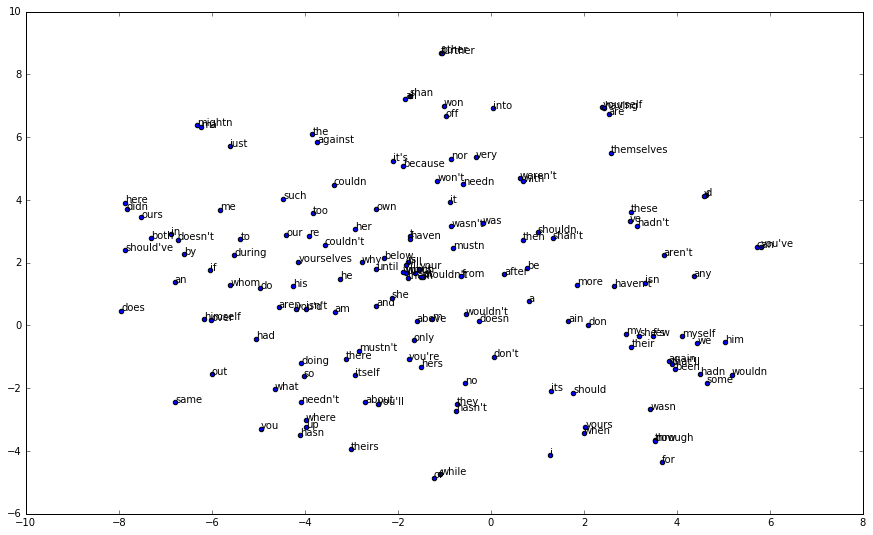

In [34]:
# here are some terms we can plot...
english_stop_words = set(nltk.corpus.stopwords.words('english'))
print(english_stop_words)
plot_terms = english_stop_words
plot_embeddings(movie_model, plot_terms)

# Now let's try to use these embeddings to do some classification. 

In [35]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the mean()
        return np.array([
            np.mean([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.vocab)

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.wv[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    
class MaxEmbeddingVectorizer(object):
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab_size = len(w2v_model.wv.vocab)

    def fit(self, X, y):
        return self

    def transform(self, X):
        # this one uses the max()
        return np.array([
            np.max([self.w2v_model.wv[w] for w in words if w in self.w2v_model.wv]
                    or [np.zeros(self.vocab_size)], axis=0)
            for words in X
        ])

In [36]:
lr_mean_w2v = Pipeline([
    ("word2vec mean vectorizer", MeanEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_max_w2v = Pipeline([
    ("word2vec max vectorizer", MaxEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

lr_tfidf_w2v = Pipeline([
    ("word2vec TF-IDF vectorizer", TfidfEmbeddingVectorizer(movie_model)),
    ("Logistic Regression", LogisticRegression())
])

In [37]:
X = [movie_reviews.words(fileid) for fileid in movie_reviews.fileids()]
# these are the categories
y_categories = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]
# this maps the strings to 1 -> positive 0 -> negative (anything else)
y = [1 if category == 'pos' else 0 for category in y_categories ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

In [38]:
lr_mean_w2v.fit(X_train,y_train)

mean_w2v_f1 = f1_score(y_test, lr_mean_w2v.predict(X_test))
print('Word2Vec mean embeddings F1 : {}'.format(mean_w2v_f1))

Word2Vec mean embeddings F1 : 0.6814814814814814


In [39]:
lr_max_w2v.fit(X_train,y_train)

max_w2v_f1 = f1_score(y_test, lr_max_w2v.predict(X_test))
print('Word2Vec max embeddings F1 : {}'.format(max_w2v_f1))

Word2Vec max embeddings F1 : 0.558974358974359


In [40]:
lr_tfidf_w2v.fit(X_train,y_train)

tfidf_w2v_f1 = f1_score(y_test, lr_tfidf_w2v.predict(X_test))
print('Word2Vec TF-IDF weighted embeddings F1 : {}'.format(tfidf_w2v_f1))

Word2Vec TF-IDF weighted embeddings F1 : 0.688279301745636


# Let's also compare against a bag of words pipeline

In [55]:
# set up a simple bag of words model
bow_pipeline = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

X_train_text = [' '.join(sentence) for sentence in X_train]
X_test_text = [' '.join(sentence) for sentence in X_test]
bow_pipeline.fit(X_train_text,y_train)

bow_f1 = f1_score(y_test, bow_pipeline.predict(X_test_text))
print('Bag of Words F1 : {}'.format(bow_f1))

Bag of Words F1 : 0.7804878048780488


In [42]:
CLUSTER_FILE_PATH = 'corpus_cluster_map.pickle'
word_cluster_map = None
with open(CLUSTER_FILE_PATH, 'rb') as f:
    word_cluster_map = pickle.load(f)
    
print('Word cluster map size : {}'.format(len(word_cluster_map)))

Word cluster map size : 32666


In [47]:
%%time

def transform_tokens_to_clusters(sentences, word_cluster_map, unknown_token = 'UNK'):
    clustered_sentences = []
    for sentence in sentences:
        clustered_sentence = []
        for token in sentence:
            cluster = unknown_token
            if token in word_cluster_map:
                cluster = str(word_cluster_map[token])
                
            clustered_sentence.append(cluster)
            
        clustered_sentences.append(clustered_sentence)
        
    return clustered_sentences

X_train_clustered = transform_tokens_to_clusters(X_train, word_cluster_map)
X_test_clustered = transform_tokens_to_clusters(X_test, word_cluster_map)

print('Size of clustered TRAIN set : {}'.format(len(X_train_clustered)))
print('Size of clustered TEST set : {}'.format(len(X_test_clustered)))

Size of clustered TRAIN set : 1600
Size of clustered TEST set : 400
Wall time: 5.73 s


In [53]:
# set up a simple bag of words model
cluster_pipeline = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                      #('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

X_train_clustered_text = [' '.join(sentence) for sentence in X_train_clustered]
X_test_clustered_text = [' '.join(sentence) for sentence in X_test_clustered]
cluster_pipeline.fit(X_train_clustered_text,y_train)

cluster_f1 = f1_score(y_test, cluster_pipeline.predict(X_test_clustered_text))
print('Word Cluster F1 : {}'.format(cluster_f1))

Word Cluster F1 : 0.7317073170731707
